# Heart Attack Causality Challenge
### Synthetic data generator

# `CausalGraphicalModels`

`CausalGraphicalModel` is a python module for describing and manipulating [Causal Graphical Models](https://en.wikipedia.org/wiki/Causal_graph) and [Structural Causal Models](https://en.wikipedia.org/wiki/Structural_equation_modeling). Behind the curtain, it is a light wrapper around the python graph library [networkx](https://networkx.github.io/).

This notebook is designed to generate data for a causality challenge.

In [1]:
from causalgraphicalmodels import StructuralCausalModel
import numpy as np
import autopandas as apd
import seaborn as sns

def conditional(causes, probabilities):
    # Compute conditional probabilities
    # Example
    # P(T|Causes[0]=F)=probabilities[0]
    # P(T|Causes[0]=T)=probabilities[1]
    n_samples = len(causes[0])
    if len(causes) == 1:
        return [np.random.binomial(n=1, p=probabilities[causes[0][i]]) for i in range(n_samples)]
    elif len(causes) == 2:
        # FF, TF, FT, TT
        return [np.random.binomial(n=1, p=probabilities[causes[0][i]][causes[1][i]]) for i in range(n_samples)]
    else:
        print('More than 2 causes, not handled.')
        return 0
    
# tests
#conditional([[0]], [0.1, 0.9])
#conditional([[0], [1]], [[0.1, 0.9], [0.5, 0.5]])

/usr/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# StructuralCausalModels

For Structural Causal Models (SCM) we need to specify the functional form of each node:

In [2]:
# HEART ATTACK GRAPH
# /!\ these values have no biological meaning, they are completely made up

scm = StructuralCausalModel({
    "blue_eyes": lambda n_samples: np.random.binomial(n=1, p=0.08, size=n_samples),
    "working": lambda n_samples: np.random.binomial(n=1, p=0.62, size=n_samples),
    "junk_food": lambda n_samples: np.random.binomial(n=1, p=0.22, size=n_samples),
    "already_had_heart_attack": lambda n_samples: np.random.binomial(n=1, p=0.01, size=n_samples),
    "appendicitis": lambda n_samples: np.random.binomial(n=1, p=0.04, size=n_samples),
    "sport": lambda n_samples: np.random.binomial(n=1, p=0.48, size=n_samples),
    "isolation": lambda n_samples: np.random.binomial(n=1, p=0.03, size=n_samples),
    "toxoplasmosis": lambda n_samples: np.random.binomial(n=1, p=0.33, size=n_samples),
    "loneliness": lambda isolation, n_samples: conditional([isolation], [0.2, 0.902]),
    "fatigue": lambda working, n_samples: conditional([working], [0.21, 0.94]),
    "stress": lambda working, fatigue, n_samples: conditional([working, fatigue], [[0.1, 0.59], [0.71, 0.98]]),
    "having_a_cat": lambda loneliness, toxoplasmosis, n_samples: conditional([loneliness, toxoplasmosis], [[0.05, 0.7], [0.5, 0.99]]),
    "fat": lambda sport, junk_food, n_samples: conditional([sport, junk_food], [[0.198, 0.93], [0.01, 0.4]]),
    "hypertension": lambda stress, fat, n_samples: conditional([stress, fat], [[0.12, 0.68], [0.712, 0.918]]),
    "heart_attack": lambda already_had_heart_attack, hypertension, n_samples: conditional([already_had_heart_attack, hypertension], [[0.002, 0.699], [0.86, 0.998]]),
    "sweating": lambda heart_attack, fat, n_samples: conditional([heart_attack, fat], [[0.02, 0.98], [0.631, 0.999]]),
    "vomiting": lambda heart_attack, appendicitis, n_samples: conditional([heart_attack, appendicitis], [[0.008, 0.85], [0.81, 0.941]])
})

In [3]:
# LUCAS GRAPH
# /!\ these values have no biological meaning, they are completely made up

#scm = StructuralCausalModel({
#    "born_even_day": lambda n_samples: np.random.binomial(n=1, p=0.49, size=n_samples),
#    "anxiety": lambda n_samples: np.random.binomial(n=1, p=0.64277, size=n_samples),
#    "peer_pressure": lambda n_samples: np.random.binomial(n=1, p=0.32997, size=n_samples),
#    "genetics": lambda n_samples: np.random.binomial(n=1, p=0.15953, size=n_samples),
#    "smoking": lambda anxiety, peer_pressure, n_samples: conditional([anxiety, peer_pressure], [[0.43118, 0.74591], [0.8686, 0.99351]]),
#    "yellow_fingers": lambda smoking, n_samples: conditional([smoking], [0.23119, 0.95372]),
#    "attention_disorder": lambda genetics, n_samples: conditional([genetics], [0.28956, 0.68706]),
#    "lung_cancer": lambda smoking, genetics, n_samples: conditional([smoking, genetics], [[0.23146, 0.86996], [0.83934, 0.99351]]),
#    "allergy": lambda n_samples: np.random.binomial(n=1, p=0.32841, size=n_samples),
#    "coughing": lambda allergy, lung_cancer, n_samples: conditional([allergy, lung_cancer], [[0.1347, 0.7664], [0.64592, 0.99947]]),
#    "fatigue": lambda coughing, lung_cancer, n_samples: conditional([coughing, lung_cancer], [[0.35212, 0.56514], [0.80016, 0.89589]]),
#    "car_accident": lambda fatigue, attention_disorder, n_samples: conditional([fatigue, attention_disorder], [[0.2274, 0.779], [0.78861, 0.97169]]),
#})

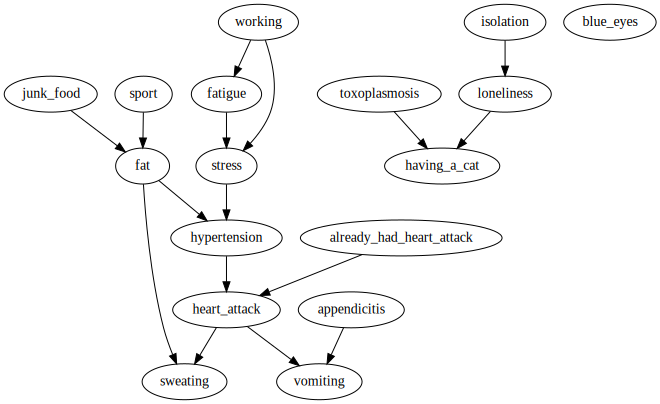

In [4]:
scm.cgm.draw()

In [13]:
data = scm.sample(n_samples=90000)
data = apd.AutoData(data)
data.train_test_split(train_size=0.4)
data.head()

,toxoplasmosis,isolation,loneliness,having_a_cat,sport,appendicitis,already_had_heart_attack,junk_food,fat,working,fatigue,stress,hypertension,heart_attack,sweating,vomiting,blue_eyes
0,1,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,1,1,1,1,1,0,0,0
2,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,1,0
3,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


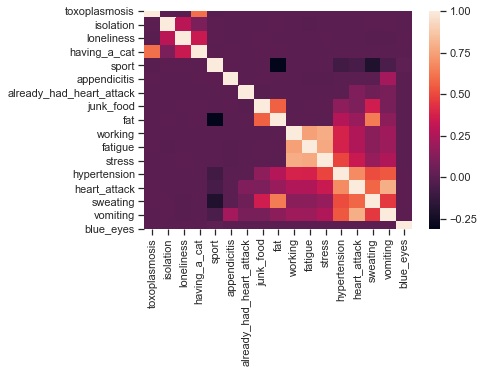

In [16]:
data.corr().plot()

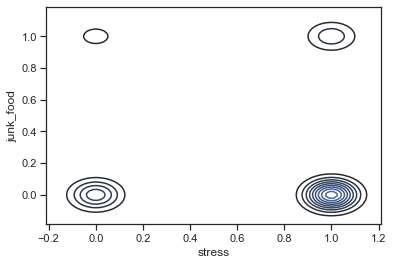

In [17]:
# and visualise the samples
%matplotlib inline

sns.kdeplot(
    data=data.stress,
    data2=data.junk_food,
)

In [18]:
# benchmark
from sklearn.metrics import roc_auc_score
data.set_class('heart_attack')
print('Accuracy: {}'.format(data.score()))
print('ROC AUC: {}'.format(data.score(metric=roc_auc_score)))

Accuracy: 0.9447407407407408
ROC AUC: 0.9379443027397003


In [19]:
# save files
data.to_automl(name='heart_attack')